# Bank Term Deposit Subscription Prediction

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
np.random.seed(123)

In [2]:
data = pd.read_csv('bank-full.csv', sep=';')

## Check null values

In [3]:
data.info() # No null-value

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 45211 entries, 0 to 45210
Data columns (total 17 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   age        45211 non-null  int64 
 1   job        45211 non-null  object
 2   marital    45211 non-null  object
 3   education  45211 non-null  object
 4   default    45211 non-null  object
 5   balance    45211 non-null  int64 
 6   housing    45211 non-null  object
 7   loan       45211 non-null  object
 8   contact    45211 non-null  object
 9   day        45211 non-null  int64 
 10  month      45211 non-null  object
 11  duration   45211 non-null  int64 
 12  campaign   45211 non-null  int64 
 13  pdays      45211 non-null  int64 
 14  previous   45211 non-null  int64 
 15  poutcome   45211 non-null  object
 16  y          45211 non-null  object
dtypes: int64(7), object(10)
memory usage: 5.9+ MB


## Drop attributes with more than 25% of unknown data

In [4]:
col_name = []
for col in data.columns:
    if type(data[col][0]) == str:
        count = len(data[data[col] == 'unknown'])
        proportion = count*100/len(data[col])
        print('the number of "unknown" in {} is {} ({:.3f}%)'.format(col,count,proportion))
        if proportion >= 25:
            data = data.drop(columns=[col]) # drop attributes with more than 25% of unknown data
        elif (proportion > 0) & (proportion < 25):
            col_name.append(col)
print(col_name)

the number of "unknown" in job is 288 (0.637%)
the number of "unknown" in marital is 0 (0.000%)
the number of "unknown" in education is 1857 (4.107%)
the number of "unknown" in default is 0 (0.000%)
the number of "unknown" in housing is 0 (0.000%)
the number of "unknown" in loan is 0 (0.000%)
the number of "unknown" in contact is 13020 (28.798%)
the number of "unknown" in month is 0 (0.000%)
the number of "unknown" in poutcome is 36959 (81.748%)
the number of "unknown" in y is 0 (0.000%)
['job', 'education']


## Check duplicate data

In [5]:
print(any(data.duplicated(keep='last'))) # No duplicate data

False


## Drop samples containing "*unknown*"

In [6]:
data = data.loc[~data.isin(['unknown']).any(1)] 
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 43193 entries, 0 to 45210
Data columns (total 15 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   age        43193 non-null  int64 
 1   job        43193 non-null  object
 2   marital    43193 non-null  object
 3   education  43193 non-null  object
 4   default    43193 non-null  object
 5   balance    43193 non-null  int64 
 6   housing    43193 non-null  object
 7   loan       43193 non-null  object
 8   day        43193 non-null  int64 
 9   month      43193 non-null  object
 10  duration   43193 non-null  int64 
 11  campaign   43193 non-null  int64 
 12  pdays      43193 non-null  int64 
 13  previous   43193 non-null  int64 
 14  y          43193 non-null  object
dtypes: int64(7), object(8)
memory usage: 5.3+ MB


## Handle the outliers

Only work on continuous features to handle the outliers. Also, features with natural patterns such as *'day'*, *'pdays'* and *'month'* are excluded for no obvious correlation with the predicted *'y'* value.

- The original data distributions of **age, balance, duration, campaign, previous** are as follows.

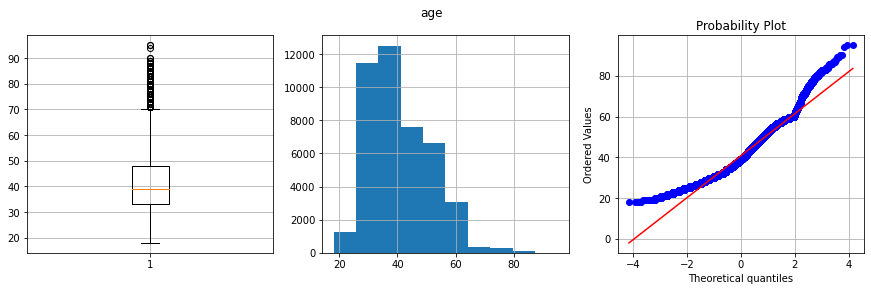

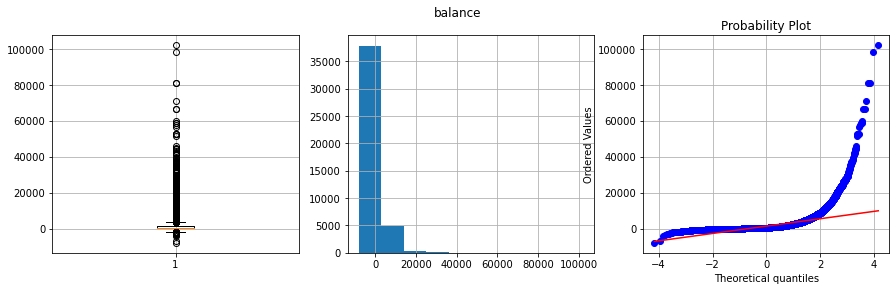

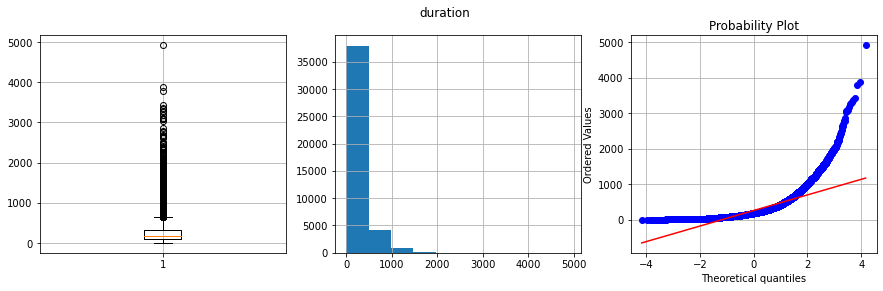

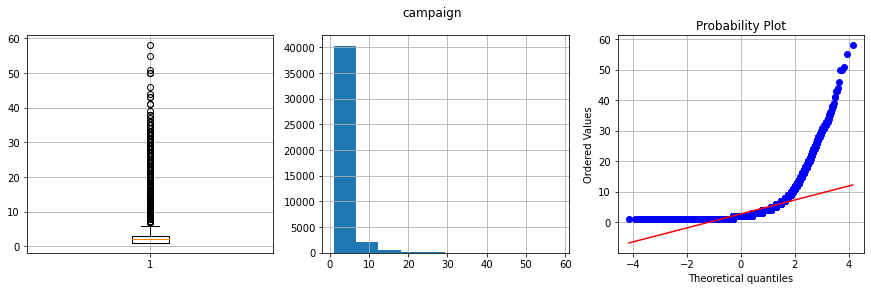

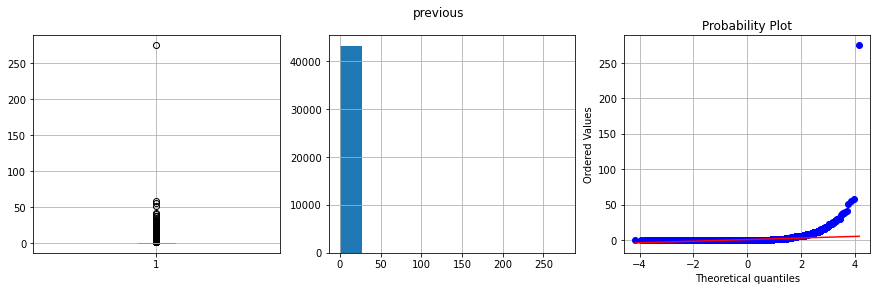

In [7]:
import scipy.stats as stats

cols = ['age', 'balance',  'duration', 'campaign', 'previous']

# display the original data distribution
for col in cols:
    fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(15,4))
    fig.suptitle(col)
    axes[0].boxplot(data[col])                             # boxplot
    axes[1].hist(data[col])                                # histogram
    stats.probplot(data[col], dist='norm', plot=axes[2])   # probability plot
    axes[0].grid()
    axes[1].grid() 
    axes[2].grid() 
 
plt.show()    

1. The balance has outliers which are greater than 50000 and smaller than -5000
2. The duration has outliers which are greater than 2500
3. The campaign has outliers which are greater than 40
4. The previous has outliers which are greater than 30
5. The age has outliers which are greater than 90

  All these outliers should be removed from the dataset based on the observation.

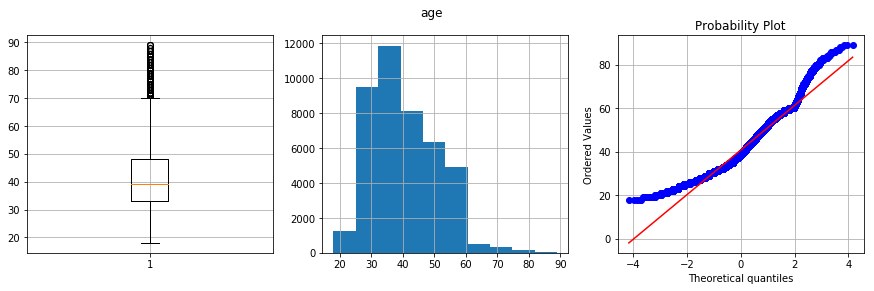

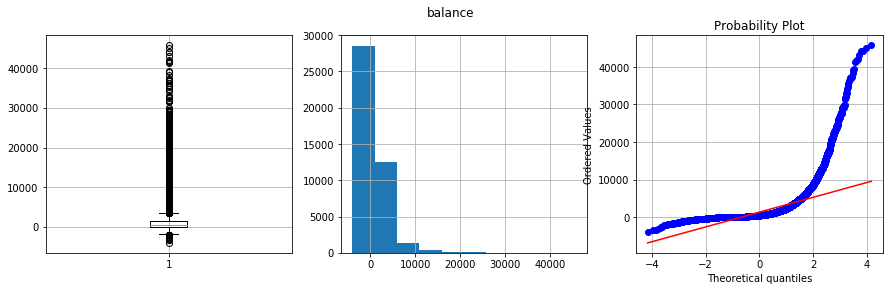

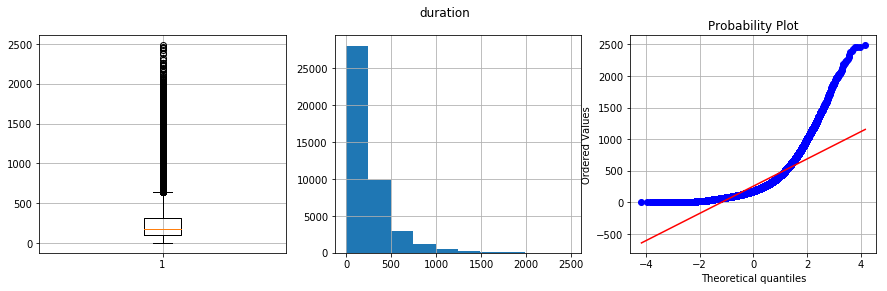

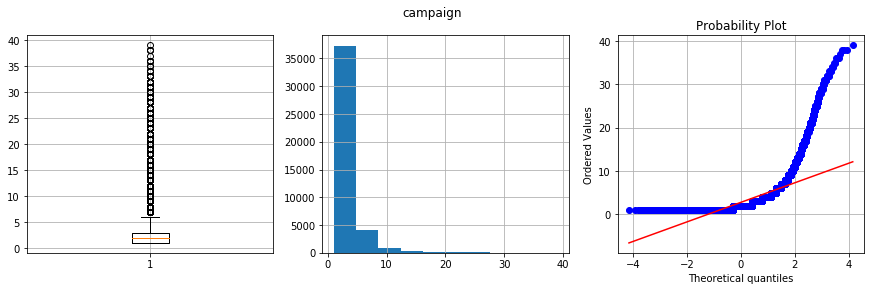

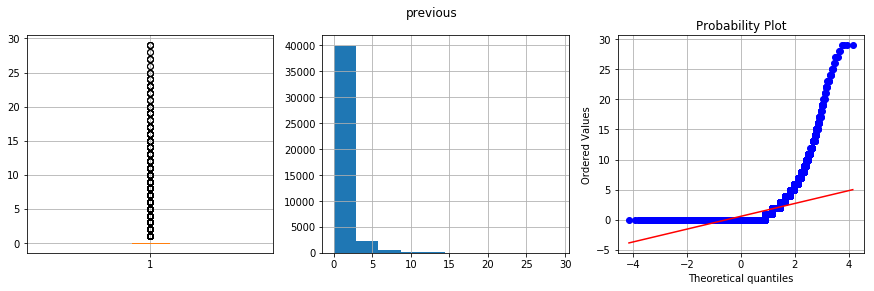

In [8]:
data = data[(data['balance']<50000)]
data = data[(data['balance']>-5000)]
data = data[(data['duration']<2500)]
data = data[(data['campaign']<40)]
data = data[(data['previous']<30)]
data = data[(data['age']<90)]

# reset indices after dropping rows
data = data.reset_index(drop=True)

cols = ['age', 'balance',  'duration', 'campaign', 'previous']

# display the processed data distribution
for col in cols:
    fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(15,4))
    fig.suptitle(col)
    axes[0].boxplot(data[col])                             # boxplot
    axes[1].hist(data[col])                                # histogram
    stats.probplot(data[col], dist='norm', plot=axes[2])   # probability plot
    axes[0].grid()
    axes[1].grid() 
    axes[2].grid() 
 
plt.show() 

## Data Visualization and Insights

- ### Subscription and contact rate by *'age'*

In [9]:
lst = [data]

# insert a classified column named 'age-group' to the dataset 
for column in lst:
    column.loc[column["age"] < 30,  'age_group'] = 20
    column.loc[(column["age"] >= 30) & (column["age"] <= 39), 'age_group'] = 30
    column.loc[(column["age"] >= 40) & (column["age"] <= 49), 'age_group'] = 40
    column.loc[(column["age"] >= 50) & (column["age"] <= 59), 'age_group'] = 50
    column.loc[column["age"] >= 60, 'age_group'] = 60

# count the percentage of different combinations between age and response y 
count_age_y_pct = pd.crosstab(data['y'], data['age_group']).apply(lambda x: x/x.sum() * 100)
count_age_y_pct = count_age_y_pct.transpose()    

# % Contacted computes the percentage of clients contacted by the bank in different age groups
# % Subscription computes the percentage of clients subscribed in different age groups
age = pd.DataFrame(data['age_group'].value_counts())
age['% Contacted'] = age['age_group']*100/age['age_group'].sum()
age['% Subscription'] = count_age_y_pct['yes']
age.drop('age_group',axis = 1,inplace = True)
age['age'] = [30,40,50,20,60]
age = age.sort_values('age',ascending = True)

age

,% Contacted,% Subscription,age
20.0,11.704545,17.297404,20
30.0,40.751391,10.556567,30
40.0,25.605288,9.029979,40
50.0,18.207328,9.310916,50
60.0,3.731447,33.685519,60


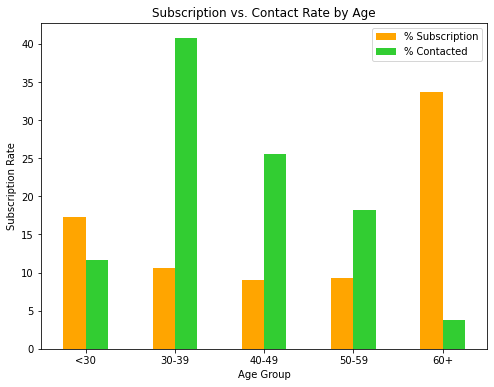

In [10]:
# plot the bar chart based on the table 'age'
plot_age = age[['% Subscription','% Contacted']].plot(kind = 'bar',
           figsize=(8,6), color = ('orange','limegreen'))
plt.xlabel('Age Group')
plt.ylabel('Subscription Rate')
plt.xticks(np.arange(5), ('<30', '30-39', '40-49', '50-59', '60+'),rotation = 'horizontal')
plt.title('Subscription vs. Contact Rate by Age')
plt.show()

**Insights** : The 60+ group contributes the most subscription at almost 35% followed by the <30 group at around 17~18%. In light of this, the bank would benefit more from the subscription if converting the target from middle-aged to older (60+) and youger(<30) clients.

- ### Subscription and contact rate by *'job'*

In [11]:
# count the percentage of different combinations between job and response y 
count_job_y_pct = pd.crosstab(data['y'], data['job']).apply(lambda x: x/x.sum() * 100)
count_job_y_pct = count_job_y_pct.transpose()    

# % Contacted computes the percentage of clients contacted by the bank in different job groups
# % Subscription computes the percentage of clients subscribed in different job groups
job = pd.DataFrame(data['job'].value_counts())
job['% Contacted'] = job['job']*100/job['job'].sum()
job['% Subscription'] = count_job_y_pct['yes']
job.drop('job',axis = 1,inplace = True)
job['job'] = ['blue-collar', 'management', 'technician', 'admin.', 'services',
       'retired', 'self-employed', 'entrepreneur', 'unemployed', 'housemaid',
       'student']
job = job.sort_values('% Subscription',ascending = False)

job

,% Contacted,% Subscription,job
student,1.794991,29.198966,student
retired,4.953618,22.518727,retired
unemployed,2.952226,15.553810,unemployed
management,21.335807,13.586957,management
admin.,11.581633,12.234682,admin.
self-employed,3.562152,11.653646,self-employed
technician,17.040816,11.077844,technician
housemaid,2.769017,8.710218,housemaid
services,9.276438,8.700000,services
entrepreneur,3.260668,8.179232,entrepreneur


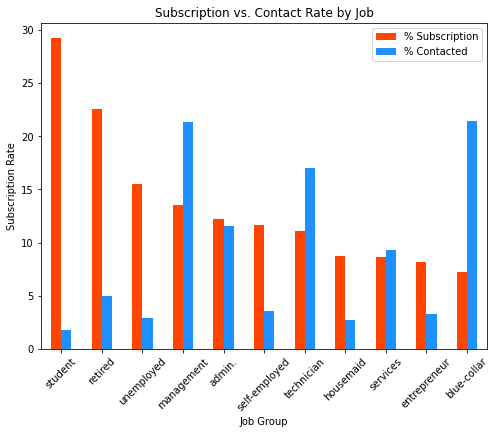

In [12]:
# plot the bar chart based on the table 'job'
plot_age = job[['% Subscription','% Contacted']].plot(kind = 'bar',
           figsize=(8,6), color = ('orangered','dodgerblue'))
plt.xlabel('Job Group')
plt.ylabel('Subscription Rate')
plt.xticks(np.arange(11), ('student', 'retired', 'unemployed', 'management', 'admin.',
       'self-employed', 'technician', 'housemaid', 'services', 'entrepreneur',
       'blue-collar'),rotation = 45)
plt.title('Subscription vs. Contact Rate by Job')
plt.show()

**Insights** : The student group contributes the greatest subscription rate at about 29% followed by the retired and unemployed group at around 23% and 15%. The bank would benefit more from the subscription if focusing on student and retired clients that totally acccount for more than 50% of the subscription

- ### Subscription distribution by *'education'*

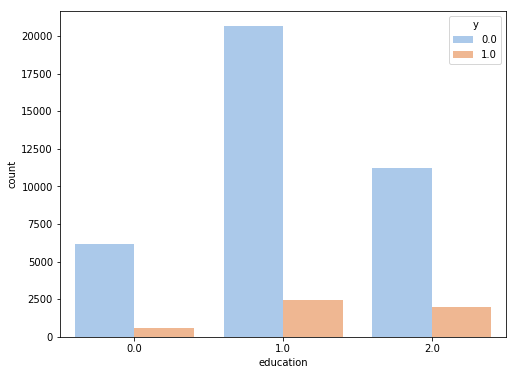

In [14]:
import seaborn as sns

plt.figure(figsize=(8,6))
sns.countplot(x="education",hue="y", data=data, palette="pastel")

**Insights** : Most clients have acquired the secondary education degree, while the subscription rate is higher in the tertiary education group of which clients are more likely to deposit.

- ### Subscription distribution by *'month'*

<AxesSubplot:xlabel='month', ylabel='count'>

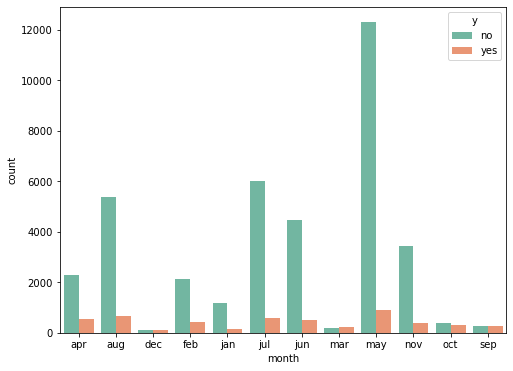

In [15]:
plt.figure(figsize=(8,6))
data.month = data.month.astype("category")
data.month.cat.set_categories(['jan','feb','mar','apr','may','jun','jul','aug','sep','oct','nov','dec'])
sns.countplot(x="month",hue="y", data=data.sort_values(['month']), palette="Set2")

**Insights** : Campaigns were actively performed in May, June, July, August and November but cannot turn to many subscriptions, i.e. the subscription rates were still low. In contrast, nearly half of contacted clients subscribed in March, September, October and December which more campaigns should be targeting at.

## Feature encoding (OrdinalEncoder)

Since categorical variables cannot be handled without encoding, the solution here is to find them and carry out the **ordinal encoding**. It transforms each categorical feature with n_categories possible values into n integer indices starting from 0.

#### Check the number of categorical features

In [9]:
data_obj = data.select_dtypes(include = 'object')
data_obj.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 43120 entries, 0 to 43119
Data columns (total 8 columns):
job          43120 non-null object
marital      43120 non-null object
education    43120 non-null object
default      43120 non-null object
housing      43120 non-null object
loan         43120 non-null object
month        43120 non-null object
y            43120 non-null object
dtypes: object(8)
memory usage: 2.6+ MB


#### Check the number of categories of these features

In [10]:
data_obj.nunique()

job          11
marital       3
education     3
default       2
housing       2
loan          2
month        12
y             2
dtype: int64

### OrdinalEncoder Implementation

In [11]:
from sklearn.preprocessing import OrdinalEncoder

# enc denotes the encoder variable
enc = OrdinalEncoder() 

columns = ['job', 'marital', 'education', 'default', 'housing', 'loan', 'month','y']
data[columns] = enc.fit_transform(data[columns])

data.head()

,age,job,marital,education,default,balance,housing,loan,day,month,duration,campaign,pdays,previous,y
0,58,4.0,1.0,2.0,0.0,2143,1.0,0.0,5,8.0,261,1,-1,0,0.0
1,44,9.0,2.0,1.0,0.0,29,1.0,0.0,5,8.0,151,1,-1,0,0.0
2,33,2.0,1.0,1.0,0.0,2,1.0,1.0,5,8.0,76,1,-1,0,0.0
3,35,4.0,1.0,2.0,0.0,231,1.0,0.0,5,8.0,139,1,-1,0,0.0
4,28,4.0,2.0,2.0,0.0,447,1.0,1.0,5,8.0,217,1,-1,0,0.0


In the new dataset, the original eight categorical features have been encoded as columns of integers. This setting helps work with continues features only.

## Data normlization

In [12]:
data_norm = (data - data.min()) / (data.max() - data.min())
data_norm.head()

,age,job,marital,education,default,balance,housing,loan,day,month,duration,campaign,pdays,previous,y
0,0.563380,0.4,0.5,1.0,0.0,0.124383,1.0,0.0,0.133333,0.727273,0.105030,0.0,0.0,0.0,0.0
1,0.366197,0.9,1.0,0.5,0.0,0.081972,1.0,0.0,0.133333,0.727273,0.060765,0.0,0.0,0.0,0.0
2,0.211268,0.2,0.5,0.5,0.0,0.081431,1.0,1.0,0.133333,0.727273,0.030584,0.0,0.0,0.0,0.0
3,0.239437,0.4,0.5,1.0,0.0,0.086025,1.0,0.0,0.133333,0.727273,0.055936,0.0,0.0,0.0,0.0
4,0.140845,0.4,1.0,1.0,0.0,0.090358,1.0,1.0,0.133333,0.727273,0.087324,0.0,0.0,0.0,0.0


## Feature engineering

### Correlation matrix

Through the correlation matrix we can know which pair of features have a strong correlation, so as to achieve the feature reduction.

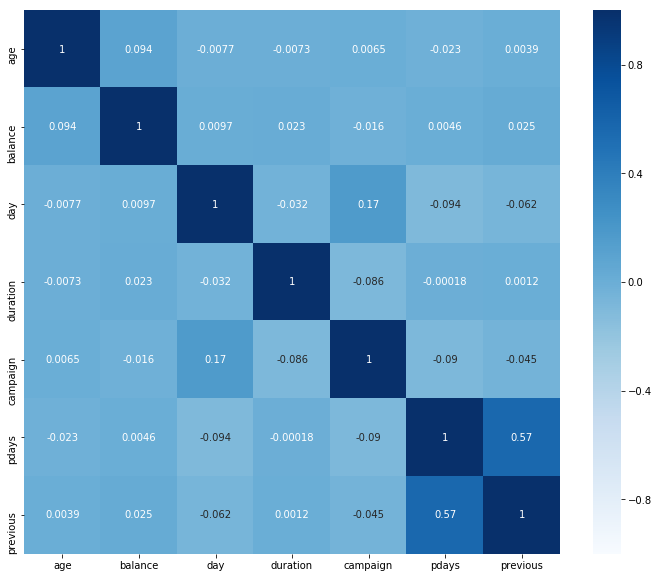

In [15]:
columns_num = ["age","balance","day","duration","campaign","pdays","previous"] # continuous attributes
df_for_feature_eng = data_norm[columns_num]
plt.figure(figsize=(12, 10))
heatmap = sns.heatmap(df_for_feature_eng.corr(), vmin=-1, vmax=1, annot=True,cmap="Blues")

*r<0.3      None or very weak*  
*0.3<r<0.5   Weak*  
*0.5≤r<0.7  Moderate*  
*0.7≤r≤1   Strong*

We can see that there is not a strong correlation between the continuous features. There is moderate correlation between *pdays* and *previous* (0.57), however, it is not enough for one of them to replace the other.

### Feature selection — Information Gain   

Here we calculate the Information Gain of each feature in the context of the output variable. Those attributes that contribute more information will have a higher information gain value and can be selected, and then use SelectKBest function to extract best features according to the 10 highest scores.

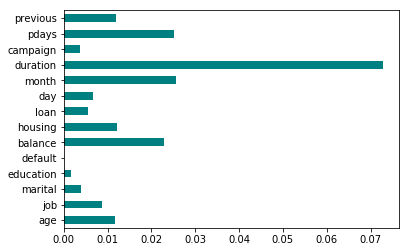

In [16]:
from sklearn.feature_selection import mutual_info_classif

Y = data_norm['y']
X = data_norm.drop(columns=['y'])
impt = mutual_info_classif(X,Y)

feat_impt = pd.Series(impt, data_norm.columns[0:len(data_norm.columns)-1])
feat_impt.plot(kind='barh',color='teal')
plt.show()

In [17]:
from sklearn.feature_selection import SelectKBest

filter_IG = SelectKBest(mutual_info_classif, k=10).fit(X, Y).get_support()
features = X.columns
f_IG = features[filter_IG]
X_IG = X[f_IG]
X = X_IG

## Spliting Data into Training and Testing Sets

In [18]:
from sklearn.model_selection import train_test_split

train_features, test_features, train_labels, test_labels = train_test_split(X,Y, test_size=0.1, stratify=Y)

In [19]:
count_train = np.unique(train_labels, return_counts=True)
count_test = np.unique(test_labels, return_counts=True)

In [20]:
count_train

(array([0., 1.]), array([34310,  4498], dtype=int64))

In [21]:
count_test

(array([0., 1.]), array([3812,  500], dtype=int64))

# Train Models

In [22]:
from sklearn.model_selection import cross_val_score
from sklearn.metrics import matthews_corrcoef
from sklearn.metrics import make_scorer

## 1. RandomForest algorithm on training data

### Tune parameters by using GridSearchCV with 5-fold Cross-Validation

"*n_estimators*", "*max_depth*" and "*max_features*" are 3 parameters that we want to explore by using GridSearchCV function. But due to the limit of our computational power, we are not able to tune these 3 parameters simultaneously. Here we tune these params in turn, like a greedy algorithm.

Firstly, we tune the parameter "*n_estimators*"

In [137]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
mcc_scorer = make_scorer(matthews_corrcoef)

# Generate RandomForest classifier with default parameters
rf = RandomForestClassifier()
a = np.arange(10,410,10) # [10,20,...,400]
param_grid = {
    'n_estimators': a
}

# Tune parameter "n_estimators"
rf_grid = GridSearchCV(estimator=rf, param_grid=param_grid,scoring=mcc_scorer,cv=5)
rf_grid.fit(train_features, train_labels)
print('Best n_estimators: ',rf_grid.best_params_)
print('The MCC Score of training dataset: ',rf_grid.best_score_)

Best n_estimators:  {'n_estimators': 370}
The MCC Score of training dataset:  0.4476986057698701


In [138]:
best_n = rf_grid.best_params_["n_estimators"]

Then, we tune the parameters "*max_depth*" and "*max_features*"

In [139]:
# Set "n_estimators" = 370
rf2 = RandomForestClassifier(n_estimators=best_n)
b = np.arange(2,14,1) # [2,3,...,13]
c = np.arange(2,9,1)  # [2,3,...,8]
param_grid = {
    'max_depth': b,
    'max_features': c
}
# Tune parameter "max_depth" and "max_features"
rf_grid2 = GridSearchCV(estimator=rf2, param_grid=param_grid,scoring=mcc_scorer,cv=5)
rf_grid2.fit(train_features, train_labels)
print(rf_grid2.best_params_)
print('The MCC Score of training dataset: ',rf_grid2.best_score_)

c:\users\msi-pc\appdata\local\programs\python\python38-32\lib\site-packages\sklearn\metrics\_classification.py:873: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)
c:\users\msi-pc\appdata\local\programs\python\python38-32\lib\site-packages\sklearn\metrics\_classification.py:873: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)
c:\users\msi-pc\appdata\local\programs\python\python38-32\lib\site-packages\sklearn\metrics\_classification.py:873: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)
c:\users\msi-pc\appdata\local\programs\python\python38-32\lib\site-packages\sklearn\metrics\_classification.py:873: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)
c:\users\msi-pc\appdata\local\programs\python\python38-32\lib\site-packages\sklearn\metrics\_classificat

{'max_depth': 13, 'max_features': 7}
The MCC Score of training dataset:  0.4483864478121887


### RandomForest model evaluation (MCC score)

In [140]:
pred = rf_grid2.predict(test_features)
print('RandomForest model MCC Score of testing dataset: ',matthews_corrcoef(test_labels, pred))

RandomForest model MCC Score of testing dataset:  0.4898928198422184


## 2. SVM (RBF kernel) algorithm on training data

In [141]:
from sklearn import svm      # Import SVM model

# Generate RBF kernel SVM classifier
clf = svm.SVC(kernel='rbf', gamma=10, class_weight='balanced')  

# Train the model with training data
clf.fit(train_features, train_labels)

# 5-fold Cross Validation using MCC scoring
mcc_scorer = make_scorer(matthews_corrcoef)
score_mcc = cross_val_score(clf,train_features, train_labels, cv=5, scoring=mcc_scorer)
print("The MCC Score of training dataset:", score_mcc.mean())

The MCC Score of training dataset: 0.47412209209220907


### SVM model evaluation (MCC score)

In [142]:
# Prediction to the test dataset
pred_labels = clf.predict(test_features)

# MCC score of testing dataset
print("SVM model MCC Score of testing dataset:", matthews_corrcoef(test_labels, pred_labels))

SVM model MCC Score of testing dataset: 0.4955307564199315


## 3. KNN algorithm on training data

In [25]:
from sklearn.neighbors import KNeighborsClassifier

### Tune parameter-k by using 5-fold Cross-Validation

best k is 3


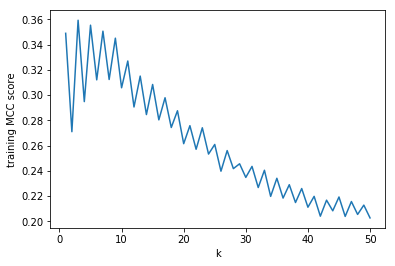

In [26]:
k_range=range(1,51)
cv_score=[]
for k in k_range:
    neigh = KNeighborsClassifier(k)
    scores = cross_val_score(neigh, train_features,train_labels,cv=5,scoring=mcc_scorer)
    score_mean = scores.mean()
    cv_score.append(score_mean)
best_k = np.argmax(cv_score)+1
print("best k is {}".format(best_k))
plt.plot(k_range,cv_score)
plt.xlabel("k")
plt.ylabel("training MCC score")
plt.show()

In [27]:
KNN = KNeighborsClassifier(best_k,weights='distance')
KNN.fit(train_features,train_labels)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=None, n_neighbors=3, p=2,
           weights='distance')

### KNN model evaluation (MCC score)

In [28]:
y_test_pred = KNN.predict(test_features)
print("KNN model MCC Score of testing dataset:", matthews_corrcoef(test_labels, y_test_pred))

KNN model MCC Score of testing dataset: 0.3684261376320488


### Analysis

Our group selected three machine learning models, which are Random Forest, Support Vector Machine (RBF Kernel) and K-Nearest Neighbor algorithm. All three models use 5-fold cross-validation on the training set to tune the hyperparameters, where the tuning of Random Forest combines cross-validation with the function GridSearchCV.

The Random Forest algorithm is an ensemble learning method of machine learning that forms an overall classifier by integrating the classification effects of multiple decision trees. Decision trees perform well on unbalanced datasets because their hierarchical structure allows them to learn from both classes. Random forests also have the advantage of low generalization error and the ability to handle high-dimensional data.

SVM is a classification boundary-based approach that can effectively handle high-dimensional datasets, efficiently classify nonlinear datasets using kernel tricks to implicitly map their inputs into a high-dimensional feature space. In addition, the SVM model are highly generalizable.

KNN is used for classification by measuring the distance between different samples. If the majority of a sample's k nearest neighbors belong to a certain class, that sample is classified in that class as well. 

From the results on the test set, the SVM model and the Random Forest model perform fairly close and both outperform the KNN model, with their scores on the MCC approaching 0.5, exceeding the KNN model's score on the MCC by about 0.1.

According to the classification principle of KNN, if the dataset is unbalanced, when classifying a new sample, the majority of the k neighbors of that sample are in the absolutely dominant category, resulting in the possibility of model misclassification and performance degradation. The dataset used in this project happens to be an unbalanced dataset, so we believe that this is an important factor why the KNN algorithm does not perform as well as the other two algorithms.

  
    
## Feature Importance 

In Random Forest, the feature importance is given in the chart below.

Text(0.5, 0, 'Random Forest Feature Importance')

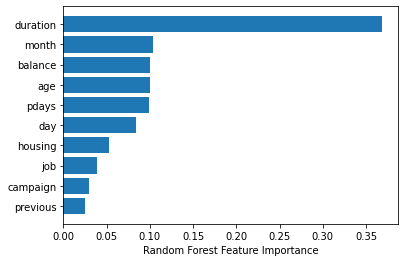

In [152]:
sorted_idx = rf_grid2.best_estimator_.feature_importances_.argsort()
plt.barh(X.columns[sorted_idx], rf_grid2.best_estimator_.feature_importances_[sorted_idx])
plt.xlabel("Random Forest Feature Importance")

# Conclusion
  

Providing with the previous analysis, the clients who tend to subscribe and the bank should target at generally possess some prominent features:

1. *age < 30 or age > 60*
2. *students or retired*
3. *secondary education*

By applying and comparing **RandomForest**, **RBF kernel SVM** and **KNN** algorithms on training dataset, **SVM** and **RandomForest** models acquire higher MCC scores and performs better than KNN. Therefore, either SVM or Random Forest could be selected to help the bank predict whether a client will subscribe to the term deposit. In addition, the subscription distribution chart regarding the feature *'month'* implies the need for more phone-call based marketing campaign during months with wretched responses. 

The above data-based strategies would depict a target customer profile for future marketing plans. The bank can allocate more marketing efforts to the clients who are classified as highly likely to accept term deposits. This will not only allow the bank to secure deposits more effectively but also increase customer satisfaction by reducing undesirable advertisements for certain clients.



# Future Directions for further Improvements

We improve both the dataset and the model.Firstly, we can balance the data set by oversampling or undersampling. Secondly, when our group tuned the random forest model, the three related parameters were tuned separately due to the computer's arithmetic power, resulting in a failure to obtain the optimal parameters, which could be modified to make the model work better by tuning all three parameters simultaneously on a better computing device.